In [5]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shutil as sh
import math
import time
from mpl_toolkits.mplot3d import Axes3D

In [15]:
class FF_phi():
    
    #ヘリンボーンパラメータとYorZ入れる。glide=a→Z, glide=b→Y
    def __init__(self,R1,R2,heri,glide):
        self.R1=R1;self.R2=R2;self.heri=heri;self.glide=glide
        self.path='C:\\Users\\youmo\\OSC\\interaction\\mono-C9-BTBT\\FF\\'
        self.interval_phi1=1#deg
        self.interval_phi2=1#deg
        self.phi1_list=np.linspace(-180.0,180.0,360.0/self.interval_phi1+1)#回転角
        self.phi2_list=[0]
        
        A_rad=np.radians(heri/2)
        self.a_=2*(R1*np.cos(A_rad)-R2*np.sin(A_rad))
        self.b_=2*(R2*np.cos(A_rad)+R1*np.sin(A_rad))
        
        #侵入の閾値
        self.inv=1.0

    #theta_in 
    def Rod(self,n,theta_in):
        nx,ny,nz=n
        theta_t=np.radians(theta_in)
        Rod=np.array([[np.cos(theta_t)+(nx**2)*(1-np.cos(theta_t)),nx*ny*(1-np.cos(theta_t))-nz*np.sin(theta_t),nx*nz*(1-np.cos(theta_t))+ny*np.sin(theta_t)],
                    [nx*ny*(1-np.cos(theta_t))+nz*np.sin(theta_t),np.cos(theta_t)+(ny**2)*(1-np.cos(theta_t)),ny*nz*(1-np.cos(theta_t))-nx*np.sin(theta_t)],
                    [nx*nz*(1-np.cos(theta_t))-ny*np.sin(theta_t),ny*nz*(1-np.cos(theta_t))+nx*np.sin(theta_t),np.cos(theta_t)+(nz**2)*(1-np.cos(theta_t))]])
        return Rod


    #分子1分子2を作成(回転させただけ・平行移動なし)
    def convertor(self,atom_list,A,phi1,phi2):#A=heri/2
        atom_list_1=[];atom_list_pa=[];atom_list_pb=[];atom_list_t1=[];atom_list_t3=[]
        #alkylの基準
        C0=np.array([atom_list[16][1],atom_list[16][2],atom_list[16][3]])
        C1=np.array([atom_list[23][1],atom_list[23][2],atom_list[23][3]])
        C2=np.array([atom_list[26][1],atom_list[26][2],atom_list[26][3]])
        
        #phi1に関するalkylの軸
        n1=C1-C0
        n1/=np.linalg.norm(n1)
        
        n2=np.cross(C0-C1,C2-C1)
        n2/=np.linalg.norm(n2)
                    
        #alkyl回転・分子1作成
        for ind,(atom,x,y,z,R,q,sig,eps) in enumerate(atom_list):
            if ind>=23:#alkyl?
                x,y,z=np.matmul(self.Rod(n2,phi2),(np.array([x,y,z])-C1).T)
                x,y,z=C1+np.array([x,y,z])
                x,y,z=np.matmul(self.Rod(n1,phi1),(np.array([x,y,z])-C0).T)
                x,y,z=C0+np.array([x,y,z])
            x1,y1,z1=np.matmul(self.Rod(np.array([0,0,1]),A),np.array([x,y,z]).T)
            atom_list_1.append([atom,x1,y1,z1,R,q,sig,eps])
        
        #並進・映進操作でp,t作成
        for atom,x,y,z,R,q,sig,eps in atom_list_1:
            atom_list_pb.append([atom,x,self.b_+y,z,R,q,sig,eps])
            atom_list_pa.append([atom,self.a_+x,y,z,R,q,sig,eps])
            
            if self.glide=='a':
                atom_list_t1.append([atom,self.a_/2+x,self.b_/2-y,z,R,q,sig,eps])
                atom_list_t3.append([atom,-self.a_/2+x,-self.b_/2-y,z,R,q,sig,eps])
                
                
            elif self.glide=='b':
                atom_list_t1.append([atom,self.a_/2-x,self.b_/2+y,z,R,q,sig,eps])
                atom_list_t3.append([atom,-self.a_/2-x,-self.b_/2+y,z,R,q,sig,eps])
                
        atom_list_others=[atom_list_pa,atom_list_pb,atom_list_t1,atom_list_t3]
        return atom_list_1,atom_list_others

    #phiの範囲を出力
    def calc_phi(self):
        df=pd.DataFrame(columns=['R1','R2','heri','phi1','phi2','FF'])
        df_mono=pd.read_csv(self.path+'monomer.csv') ###x,y,z,rad
        monomer=df_mono[['atom','X','Y','Z','R','q','sig','eps']].values
        e=1.602176634*(10**(-19))

        for phi1 in self.phi1_list:
            for phi2 in self.phi2_list:
                BTBT_1,BTBT_others=self.convertor(monomer,self.heri/2,phi1,phi2)

                #FF
                FF=0

                #アルキルの各原子同士が衝突したらbreak
                for ind1,(atom1,x1,y1,z1,R1,q1,sig1,eps1) in enumerate(BTBT_1[23:]):
                    for ind2,BTBT_2 in enumerate(BTBT_others):
                        for ind3,(atom2,x2,y2,z2,R2,q2,sig2,eps2) in enumerate(BTBT_2[23:]):
                            
                            r=np.linalg.norm([x1-x2,y1-y2,z1-z2])
                            q=q1*q2*(e**2)
                            sig=np.sqrt(sig1*sig2)
                            eps=np.sqrt(eps1*eps2)
                            FF+=q/r+4*eps*((sig/r)**12-(sig/r)**6)

                data=pd.Series([self.R1,self.R2,self.heri,phi1,phi2,FF],index=['R1','R2','heri','phi1','phi2','FF'])
                df=df.append(data,ignore_index=True)
        df.to_csv(self.path+'FF_phi.csv',index=False)



# Y-type

In [36]:
FF=FF_phi(R1=5.0,R2=1.0,heri=58.0,glide='b')

In [37]:
FF.calc_phi()

In [9]:
# df_FF=pd.read_csv(FF.path+'FF_phi.csv')
# plt.rcParams['figure.figsize']=10,10
# plt.pie(np.ones(361),colors=[str(color) for color in FF_plot],counterclock=False,startangle=FF.heri/2+90-180)
# plt.show()

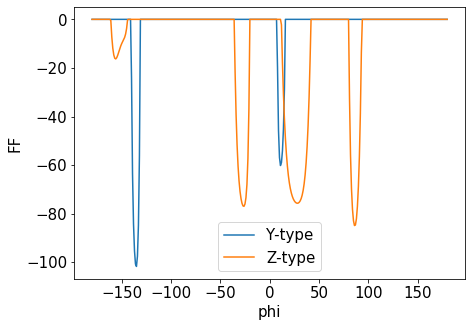

In [39]:
df_FF=pd.read_csv(FF.path+'FF_Ymin_phi.csv')
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=7,5
plt.xlabel('phi')
plt.ylabel('FF')
FF_Y_plot=[min(FF,0) for FF in df_FF['FF']]#-min(df_FF['FF']))/(0-min(df_FF['FF']))
plt.plot(FF.phi1_list,FF_Y_plot,label='Y-type')
plt.plot(FF.phi1_list,FF_plot,label='Z-type')
plt.legend()

# Z-type

In [29]:
FF=FF_phi(R1=5.0,R2=0.7,heri=58.0,glide='a')

In [22]:
FF.calc_phi()

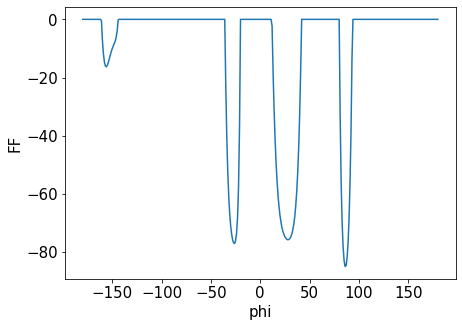

In [30]:
df_FF=pd.read_csv(FF.path+'FF_phi.csv')
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=7,5
plt.xlabel('phi')
plt.ylabel('FF')
FF_plot=[min(FF,0) for FF in df_FF['FF']]#-min(df_FF['FF']))/(0-min(df_FF['FF']))
plt.plot(FF.phi1_list,FF_plot)

### YorZのalkyl比較用

In [10]:
#FF=FF_phi(R1=5.0,R2=0.7,heri=58.0,glide='a')
FF=FF_phi(R1=5.0,R2=1.0,heri=58.0,glide='b')
df_mono=pd.read_csv(FF.path+'monomer.csv') ###x,y,z,rad
monomer=df_mono[['atom','X','Y','Z','R','q','sig','eps']].values
BTBT_1,BTBT_others=FF.convertor(monomer,FF.heri/2,phi1=-135.0,phi2=0.0)
df_min=pd.DataFrame(columns=['atom','X','Y','Z','R','q','sig','eps'],data=BTBT_1+BTBT_others[0]+BTBT_others[1]+BTBT_others[2]+BTBT_others[3])
df_min.to_csv("C:\\Users\\youmo\\OneDrive\\Y_test.csv",index=False)